# 1. Developing a model for classification
Data source: https://www.kaggle.com/datasnaek/league-of-legends.

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from collections import defaultdict


# sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score #
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, brier_score_loss, log_loss, precision_score, recall_score)
from sklearn.metrics import classification_report

games_raw = pd.read_csv('C:/Users/xsoni/Desktop/league_of_legends_ranked_games/games.csv')

## Data handling summary
- Removed duplicate rows, we don't want the same game to appear multiple times in our data.
- Renamed team2 to team0 and changed values correspondingly for convenience.
- Kept only variables relating to team statistics to keep it simple.

In [2]:
# drop duplicate values
games_temp = games_raw.drop_duplicates()

# we keep only the variables that we want to keep for our model and encode team 1 as 1 and team 2 as 0 instead of 2
games_part1 = games_temp[['winner', 'firstBlood', 'firstTower', 'firstInhibitor'
                          , 'firstBaron' ,'firstDragon', 'firstRiftHerald']]%2

games_part2 = games_temp[['t1_towerKills', 't1_inhibitorKills', 't1_baronKills', 't1_dragonKills', 't1_riftHeraldKills'
                       ,'t2_towerKills', 't2_inhibitorKills', 't2_baronKills', 't2_dragonKills', 't2_riftHeraldKills']]

games_part2 = games_part2.rename(columns={'t2_towerKills': 't0_towerKills','t2_inhibitorKills': 't0_inhibitorKills'
                                         ,'t2_baronKills': 't0_baronKills' ,'t2_dragonKills': 't0_dragonKills'
                                         ,'t2_riftHeraldKills': 't0_riftHeraldKills'}, errors="raise")

games = pd.concat([games_part1, games_part2], axis=1)
games

,winner,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,firstRiftHerald,t1_towerKills,t1_inhibitorKills,t1_baronKills,t1_dragonKills,t1_riftHeraldKills,t0_towerKills,t0_inhibitorKills,t0_baronKills,t0_dragonKills,t0_riftHeraldKills
0,1,0,1,1,1,1,0,11,1,2,3,0,5,0,0,1,1
1,1,1,1,1,0,1,1,10,4,0,2,1,2,0,0,0,0
2,1,0,1,1,1,0,0,8,1,1,1,0,2,0,0,1,0
3,1,1,1,1,1,1,0,9,2,1,2,0,0,0,0,0,0
4,1,0,1,1,1,1,0,9,2,1,3,0,3,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51485,0,1,0,0,0,0,0,2,0,0,0,0,10,2,0,4,0
51486,0,1,1,0,0,0,0,5,4,0,2,0,11,7,4,4,1
51487,0,0,0,0,0,1,0,0,0,0,1,0,10,2,0,2,0
51488,0,0,0,0,0,0,0,0,0,0,0,0,11,3,0,1,0


In [3]:
print('Correlations against the winner variable: \n' , games.corr()['winner'].sort_values())

Correlations against the winner variable: 
 t0_towerKills        -0.785722
t0_inhibitorKills    -0.660696
t0_dragonKills       -0.497055
t0_baronKills        -0.398692
t0_riftHeraldKills   -0.226131
firstBlood            0.180038
firstRiftHerald       0.218057
t1_riftHeraldKills    0.218057
firstDragon           0.344566
t1_baronKills         0.369883
firstBaron            0.387115
firstTower            0.406367
t1_dragonKills        0.472635
t1_inhibitorKills     0.649636
firstInhibitor        0.724602
t1_towerKills         0.771571
winner                1.000000
Name: winner, dtype: float64


Note that the correlations are more or less symmetric with respect to team for the team specific variables.

In [4]:
# train test split
X = games.drop(['winner'], axis='columns')
y = games['winner']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    shuffle=True, random_state=2) # gives us 10,2k test games

## Models that we will consider:
All three models can output probabilities for their classifications and further, all three models can be set to minimize log-loss during their fitting.

### Logistic regression (linear in input variables, default settings except for removing intercept)  
- This model is included because of the high correlations between some of the inputs with the target variable. The data is constrained by the game mechanics such that there is an absence of outliers, this usually improves the model performance and allows the model to generalize to new data.

OBS! There may exist major issues with this model - multicollinearity, residuals not being normal, input and target variables having a slight non-linear relationship etc - which we will not consider because it is out of scope for this project. The model performance may suffer from this.

### Decision tree and random forest (with parameters hypertuned, using a grid search with cross validation, for accuracy)  
- In comparison to the logistic regression these models have the potential to pick up on non-linear relationships between the input variables and the target variable. 
- The models may also pick up synergistic relationships, such as the fact that, unless a team surrenders early, then, for a team to win it must have killed at least 5 towers and 1 inhibitor (to be able to attack the nexus). This is something that logistic regression will not be able to pick up unless included in feature engineering (this new variable would however be strongly correlated with number of towers and inhibitors killed).
- The models handles collinearity well. 
- Again, because the data is constrained by the game mechanics we can expect these models to generalize well to new data.

### We start by hypertuning the tree models for accuracy

In [10]:
# decision tree
print('\ndecision tree: ')
dt_criterion=['log_loss','gini', 'entropy']
dt_max_depth=range(5,9,1)
dt_splitter=['best', 'random']
dt=DecisionTreeClassifier()
dt_grid=GridSearchCV(estimator=dt,cv=10,
                                param_grid=dict(criterion=dt_criterion
                                                ,max_depth=dt_max_depth
                                                ,splitter=dt_splitter))
dt_grid.fit(X_train,y_train)
print('mean accuracy with tuned hyperparameters: ', dt_grid.best_score_)
print('tuned hyperparameters: ', dt_grid.best_params_)


# random forest
print('\nrandom forest: ')
rf_criterion=['log_loss', 'gini', 'entropy']
rf_max_depth=range(2,4,1)
rf=RandomForestClassifier()
rf_grid=GridSearchCV(estimator=rf,cv=10, 
                     param_grid=dict(n_estimators=[50] # to avoid longer runtimes
                                     , criterion=rf_criterion
                                     ,max_depth=rf_max_depth))
rf_grid.fit(X_train,y_train)
print("mean accuracy with tuned hyperparameters: ", rf_grid.best_score_)
print("tuned hyperparameters: ", rf_grid.best_params_)

logistic regression: 
mean acc:  0.9632731668019329 
range:  0.0071008814887365546

decision tree: 
mean accuracy with tuned hyperparameters:  0.9683415831791857
tuned hyperparameters:  {'criterion': 'gini', 'max_depth': 8, 'splitter': 'best'}

random forest: 
mean accuracy with tuned hyperparameters:  0.9568581633913039
tuned hyperparameters:  {'criterion': 'gini', 'max_depth': 3, 'n_estimators': 50}


## Model comparison

In [18]:
# initiate chosen classifiers
lr = LogisticRegression(fit_intercept=False)
dt = DecisionTreeClassifier(criterion='gini',max_depth=8, splitter='best')
rf = RandomForestClassifier(n_estimators = 50, max_depth=3, criterion='gini')

classifier_list = [
    (lr, "Logistic Regression ")
    ,(dt, "Decision Tree")
    ,(rf, "Random Forest")
            ]

# get metrics for chosen classifiers
scores = defaultdict(list)
for i, (clf, name) in enumerate(classifier_list):
    clf.fit(X_train, y_train)
    y_prob = clf.predict_proba(X_test)
    y_pred = clf.predict(X_test)
    scores["Classifier"].append(name)

    for metric in [accuracy_score, precision_score, recall_score]:
        score_name = metric.__name__.replace("_", " ").replace("score", "")
        scores[score_name].append(metric(y_test, y_pred))

    score_df = pd.DataFrame(scores).set_index("Classifier")

score_df.round(decimals=3)

,accuracy,precision,recall
Classifier,,,
Logistic Regression,0.962,0.965,0.960
Decision Tree,0.968,0.969,0.967
Random Forest,0.958,0.972,0.944


### Notes:
- Accuracy is similar for all models, especially logistic regression and the decision tree, but the decision tree has the highest accuracy. It is possible that the logistic regression model would have outperformed the decision tree model in terms of accuracy had we feature engineered such that the logistic regression model could better pick up non-linear relationships which may exist between the target variable and predictor variables. Of course, the tree models hypertuning might have been subpar as well.
- Precision and recall are almost equal for all models. This is to be expected if the data is balanced in terms of wins and losses for both teams in the training data. In fact, we could have used a stratified cross validation to make sure of this. One expects precision and recall to be alike for our models because the features used are symmetric.

## Test data performance
Because our goal in this step is to pick a model that performs well with respect to classifications and precision $\approx$recall we simply go with the model that maxmizes accuracy under validation.

In [14]:
dt = DecisionTreeClassifier(criterion='gini',max_depth=8, splitter='best')
dt.fit(X_train, y_train)
print(classification_report(y_test, dt.predict(X_test), digits=3))

              precision    recall  f1-score   support

           0      0.966     0.969     0.967      5038
           1      0.969     0.967     0.968      5173

    accuracy                          0.968     10211
   macro avg      0.968     0.968     0.968     10211
weighted avg      0.968     0.968     0.968     10211



The accuracy is the same on the test data as for the mean of cross validation accuracies. The model seems to generalizes well to new data.

# 2. Developing a model for probability estimates
## What is the true probability $p=P('\text{team 1 wins}')$? Can it be known?  

What exactly is meant by a true probability is more of a philosphical question, but no matter what philosophical perspective we take (frequentist, randomness is lack of knowledge, degrees of belief) we still can not know the true probability. The conclusion is that an exact quanitity of a distance between the estimate $\hat{p}$ and the true probability $p$, that is, $d(p,\hat{p})$ can not be given.

We cab however use heuristics by comparing estimated probabilities that the true classification which we do know. In this section we will look at how to do this using Brier score, log-loss and calibration curves.

Let's begin by looking at probability calibration curves for the models chosen for accuracy.

## Probability calibration curves
Say our model estimates that team 1 has 80% win probability given a certain game state. If we look at the frequency of games in that game state, how often did team 1 actually win? We answer this approximately by creating bins, and looking at a frequency histogram. For each bin, say a 80-85% (probability estimate that team 1 wins) bin, we look at the frequency of games where the outcome actually occured, for example: $\frac{\text{times team 1 won and model predicted 80-85% win probability}}{\text{#total games where model predicted 80-85% win probability}}$, we would like this ratio to be about 0.8-0.85 (preferably 0.825) for a well calibrated model.

If we apply the same logic to all bins 0%-5%, 5%-10%, etc and then plot the ratio described above, we would except a straight line if the model is perfectly calibrated and close to a straight line if it is well calibrated, the further away, the less reliable the model will be in making probability estimates.


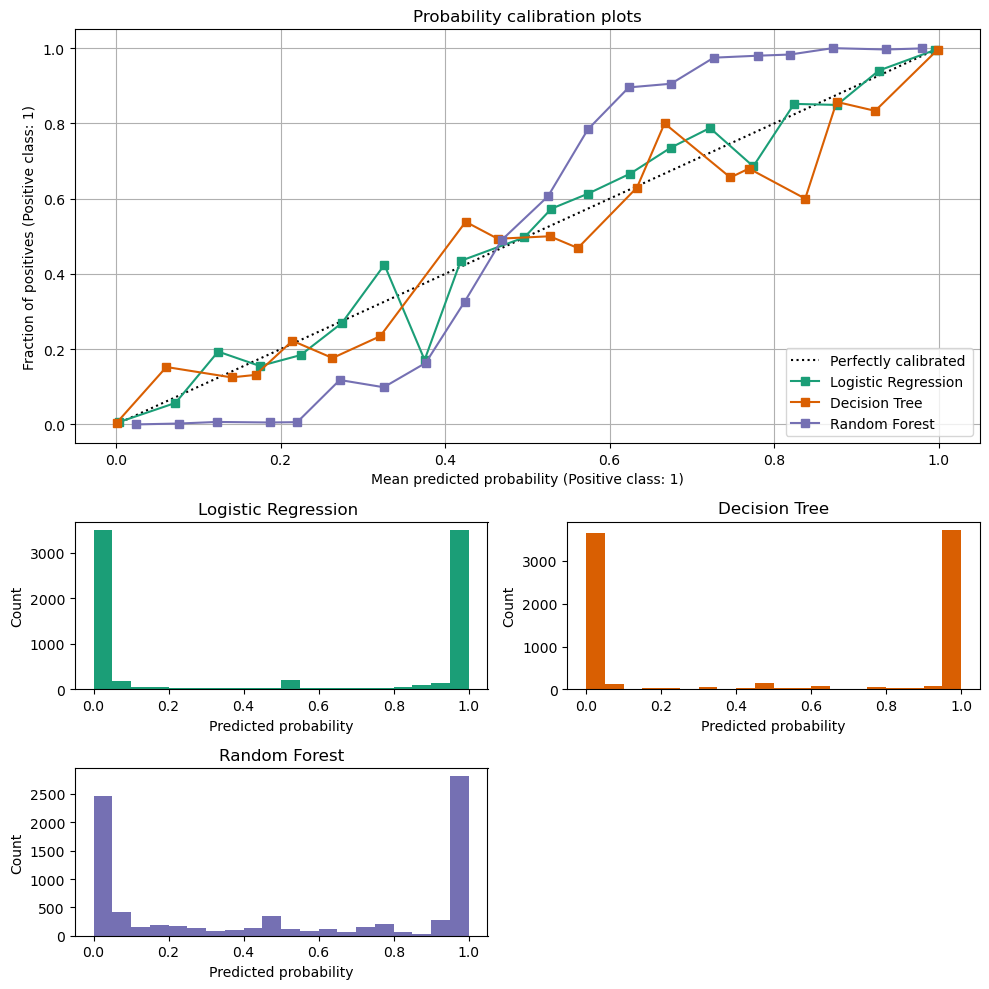

In [37]:
log_reg = LogisticRegression(fit_intercept=False)
dt = DecisionTreeClassifier(criterion='gini',max_depth=8, splitter='best')
rf = RandomForestClassifier(max_depth=3, criterion='gini')

classifier_list = [
    (log_reg, "Logistic Regression ")
    ,(dt, "Decision Tree")
    ,(rf, "Random Forest")
            ]

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")

# split train into train and validation to keep test data held out until we have chosen a model
X_train_2, X_validation, y_train_2, y_validation = train_test_split(X_train, y_train, test_size=0.2, 
                                                    shuffle=True, random_state=2)

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(classifier_list):
    clf.fit(X_train_2, y_train_2)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_validation,
        y_validation,
        n_bins=20,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Probability calibration plots")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(classifier_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=20,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

### Notes on calibration plot
- Sampling more data or using wider bins makes the calibration plot curves look more stable, the reason for their squiggly-ness (high variation between bins) may be due to the fact that there are not that many games where the models predict close to even probabilites - which we can see from the histograms below.
- The logistic regression model and decision tree model similar performance in this regard. One can expect the logistic regression model to perform quite well here because during training log-loss is minimized, which is a metric for the difference between the predicted and actual probability distributions. Next we will see what happends when we train tree models to perform with respect to log loss and brier score.
- The Random forest model is poorly calibrated. The model seems to be unconfident in it's classification, i.e giving for example 60% probability estimate when it ought to give about 90%. As the data comes from finished games, we expect the models to be able to be highly confident (hence also the high accuracy of all models). We see here that even if the random forest model does almost as well as the other models with respect to accuracy, it does not give good probability estimates (at least not with the given parameters).

### Do we want to focus on log loss or brier score?
Log-loss is given by
$ -\frac{1}{n} \sum_{i=1}^n y_i log(\hat{p(y_i)} + (1-y_i)log(1-\hat{p(y_i)})  $  
where $y_i$ is an indicator of team 1 winning say, and $\hat{p(y_i)}$ is a models estimated of the same. If we predict wrong we add $(\hat{p(y_i)}$ or $(1-y_i)log(1-\hat{p(y_i)}$ depending on which mistake we made, 


Brier score
$$

differnece between log loss and brier score? both metrics are used to calibrate corresponding curves in calibrtion plot! how do they compare in this case?


- More on Brier score and log-loss:  
https://machinelearningmastery.com/probability-metrics-for-imbalanced-classification/#:~:text=Log%20loss%20quantifies%20the%20average,between%20predicted%20and%20expected%20probabilities  
and  
https://towardsdatascience.com/introduction-to-probabilistic-classification-a-machine-learning-perspective-b4776b469453  
see also sklearns pages on both for more
- More on cross validation  
 https://machinelearningmastery.com/training-validation-test-split-and-cross-validation-done-right/
 
- More on calibration plots  
https://scikit-learn.org/stable/modules/calibration.html  
and  
https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html



### The log loss score that heavily penalizes forecasted probabilities far away from their predicted value, brier score does the same but is gentler.
https://aicorespot.io/an-intro-to-probability-scoring-strategies-in-python-2/

### We hypertune tree models to perform with respect to brier score and log loss.

In [ ]:
# decision tree
print('\ndecision tree: ')
dt_criterion=['log_loss','gini', 'entropy']
dt_max_depth=range(5,9,1)
dt_splitter=['best', 'random']
dt=DecisionTreeClassifier()
dt_grid=GridSearchCV(estimator=dt,cv=10,
                                param_grid=dict(criterion=dt_criterion
                                                ,max_depth=dt_max_depth
                                                ,splitter=dt_splitter))
dt_grid.fit(X_train,y_train)
print('mean accuracy with tuned hyperparameters: ', dt_grid.best_score_)
print('tuned hyperparameters: ', dt_grid.best_params_)






rf2=RandomForestClassifier()
grid_rf2=GridSearchCV(estimator=rf2,cv=10, scoring='neg_brier_score', 
                      param_grid=dict(criterion=criterion,max_depth=max_depth))

rf3=RandomForestClassifier()
grid_rf3=GridSearchCV(estimator=rf2,cv=10, scoring='neg_log_loss', 
                      param_grid=dict(criterion=criterion,max_depth=max_depth))

criterion=["gini","entropy", 'log_loss']
max_depth=range(1,5,1)
rf=RandomForestClassifier()
grid_rf2.fit(X_train,y_train)

print("best score: ", grid_rf2.best_score_)
print("best param: ", grid_rf2.best_params_)

grid_rf3.fit(X_train,y_train)
print("best score: ", grid_rf3.best_score_)
print("best param: ", grid_rf3.best_params_)









# random forest
print('\nrandom forest: ')
rf_criterion=['log_loss', 'gini', 'entropy']
rf_max_depth=range(2,4,1)
rf=RandomForestClassifier()
rf_grid=GridSearchCV(estimator=rf,cv=10, 
                     param_grid=dict(n_estimators=[50] # to avoid longer runtimes
                                     , criterion=rf_criterion
                                     ,max_depth=rf_max_depth))
rf_grid.fit(X_train,y_train)
print("mean accuracy with tuned hyperparameters: ", rf_grid.best_score_)
print("tuned hyperparameters: ", rf_grid.best_params_)

In [ ]:
scores = defaultdict(list)
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, Y_train)
    y_prob = clf.predict_proba(X_test)
    y_pred = clf.predict(X_test)
    scores["Classifier"].append(name)

    for metric in [brier_score_loss, log_loss]:
        score_name = metric.__name__.replace("_", " ").replace("score", "")
        scores[score_name].append(metric(Y_test, y_prob[:, 1]))

    for metric in [accuracy_score]:
        score_name = metric.__name__.replace("_", " ").replace("score", "")
        scores[score_name].append(metric(Y_test, y_pred))

    score_df = pd.DataFrame(scores).set_index("Classifier")
    
score_df.round(decimals=3)

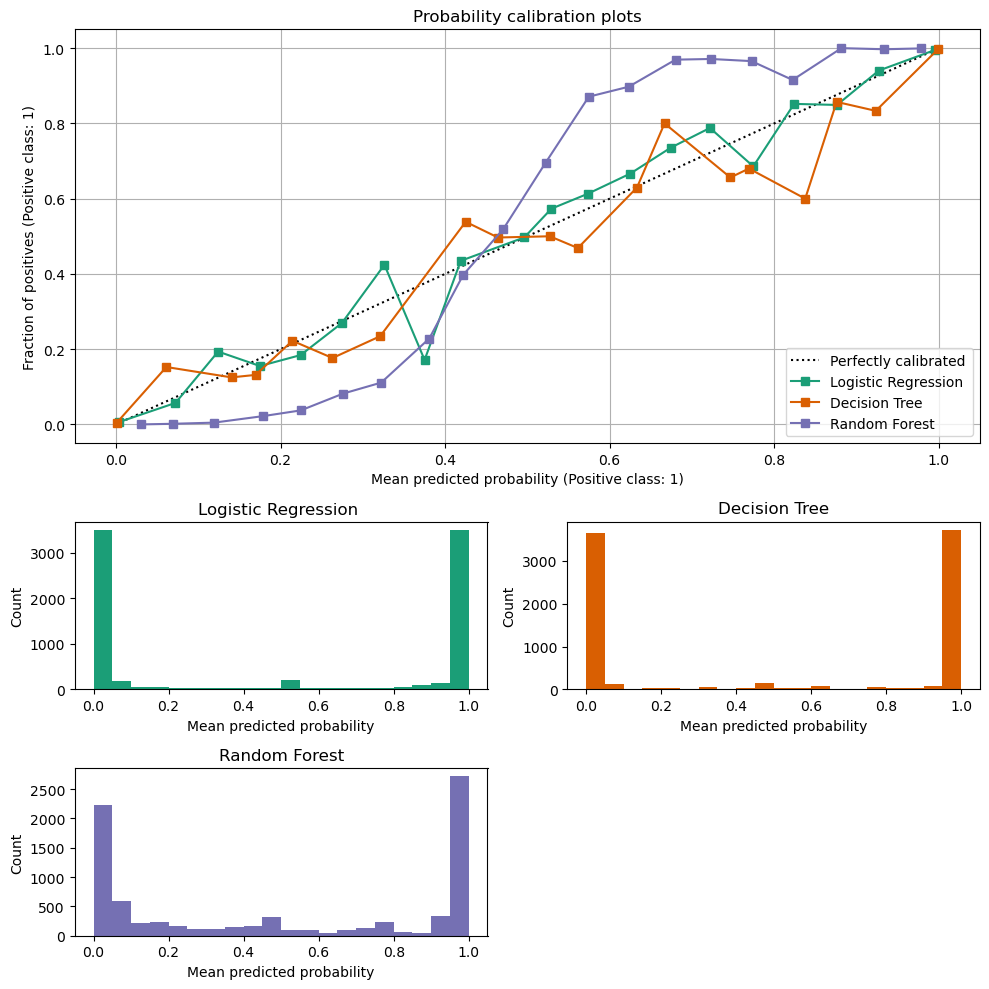

In [40]:
log_reg = LogisticRegression(fit_intercept=False)
dt = DecisionTreeClassifier(criterion='gini',max_depth=8, splitter='best')
rf = RandomForestClassifier(max_depth=3, criterion='gini')

classifier_list = [
    (log_reg, "Logistic Regression ")
    ,(dt, "Decision Tree")
    ,(rf, "Random Forest")
            ]

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")

# split train into train and validation to keep test data held out until we have chosen a model
X_train_2, X_validation, y_train_2, y_validation = train_test_split(X_train, y_train, test_size=0.2, 
                                                    shuffle=True, random_state=2)

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(classifier_list):
    clf.fit(X_train_2, y_train_2)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_validation,
        y_validation,
        n_bins=20,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display
    

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Probability calibration plots")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(classifier_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=20,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

- Model mostly just makes very sure predictions with <0.05 or >0.95 probability. This is not totally unexpected as the data we have is from finished games. This however means that we have few observations in the bins where the model predicted something inbetween and hence the observed calibration curves are prone to high variation, hence the squiggly-ness.

# 3. Given more time I would expand the project by looking into:
- Champion type setup for both teams and length of game:
In my experience playing hon and dota, sometimes one team has problems ending the game and as time progresses the team that was losing turns the game around because they are 3-5 carrys that are getting well-equipped.
- Different model for predicting outcome given early surrender (i.e before the pre-requiste of killing at least 5 towers and 1 inhibitor such that the nexus can be attacked)

### Notes on dropped variables:
- creationTime: no predictive power unless our model takes chronological order into account (ex skill development)
- selection of champions and bans: there is likely signal in the choice of champions. 
- gameDuration: can probably be very useful for more complex modeling and synergies with other variables (ex: team setup, if a team does not end "early" against 5 carrys then they usually end up losing).

# Get the proportion of games that "end early" to see if it is approx 4%, a separate model might be useful for such

In [15]:
games_raw[games_raw] 

,gameId,creationTime,gameDuration,seasonId,winner,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,...,t2_towerKills,t2_inhibitorKills,t2_baronKills,t2_dragonKills,t2_riftHeraldKills,t2_ban1,t2_ban2,t2_ban3,t2_ban4,t2_ban5
0,3326086514,1504279457970,1949,9,1,2,1,1,1,1,...,5,0,0,1,1,114,67,43,16,51
1,3229566029,1497848803862,1851,9,1,1,1,1,0,1,...,2,0,0,0,0,11,67,238,51,420
2,3327363504,1504360103310,1493,9,1,2,1,1,1,2,...,2,0,0,1,0,157,238,121,57,28
3,3326856598,1504348503996,1758,9,1,1,1,1,1,1,...,0,0,0,0,0,164,18,141,40,51
4,3330080762,1504554410899,2094,9,1,2,1,1,1,1,...,3,0,0,1,0,86,11,201,122,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51485,3308904636,1503076540231,1944,9,2,1,2,2,0,2,...,10,2,0,4,0,55,-1,90,238,157
51486,3215685759,1496957179355,3304,9,2,1,1,2,2,2,...,11,7,4,4,1,157,55,119,154,105
51487,3322765040,1504029863961,2156,9,2,2,2,2,0,1,...,10,2,0,2,0,113,122,53,11,157
51488,3256675373,1499562036246,1475,9,2,2,2,2,0,2,...,11,3,0,1,0,154,39,51,90,114
